# Geo877 Spatial Algorithms - Group Alivand
# Hiking Route Recommendation in Jungfrau Region, Switzerland
### Extracting Scenic Routes from VGI Data Sources 


Currently, we have chosen the Jungfrau Region as our study area. We are using road network data from Swiss Map Vector 25, Layer Name: DKM25_Strasse. The data source can be found on the [SwissTopo website](https://www.swisstopo.admin.ch/de/landeskarte-swiss-map-vector-25). Our data for Scenicness comes from Arealstatistik.

In [1]:
from Geo877_Alivand import *
from Geo877_Alivand import find_connected_components, get_largest_component, filter_graph, MergeMitnodes, preprocess_gdf, preprocess_gdf_to_edge_list, Graph, Graph_matrix
import os
import getpass
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import MultiLineString, Point, LineString
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

In [2]:
# Use this to get the current user name, as it will be needed later to access files
user_name = getpass.getuser()

## Setup

Setting up the network

## Graph processing
Processing the original gpkg file to generates graph.
### Build temporary graph
We built a temporary graph based on the original gpkg file. We develop three different kinds of data structure to store graph. They are adjacency list, adjacency matrix and edge list.

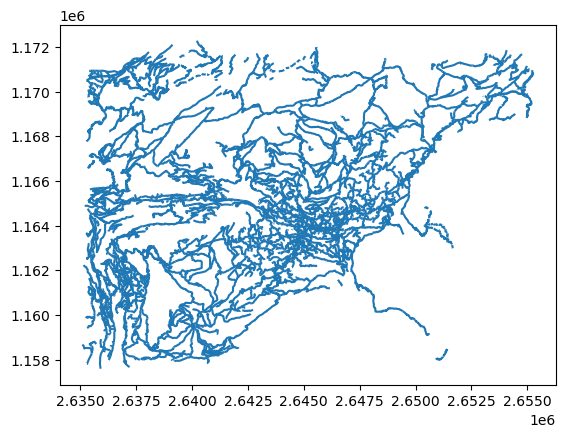

In [3]:
gdf = gpd.read_file('Roads_small.gpkg')
graph = preprocess_gdf(gdf)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
plt.show()

### Clean origional graph
In the original graph, there are some nodes that are not connected to any other nodes in this undirected graph, but we consider that a node in an undirected graph should be able to reach any other node in this graph，so we clean the original graph through a DFS algorithm.

In [4]:
def dfs_component(graph, node, component):
    # Add the current node to the component
    component.add(node)
    print(node)

    # Iterate over all neighbors of the current node
    for neighbor in graph.adj[node]:
        print(neighbor)
        # If the neighbor is not already in the component
        if neighbor not in component:
            # Recursively perform DFS on the neighbor
            dfs_component(graph, neighbor, component)

In [5]:
def find_connected_components(graph):
    # Initialize a set to keep track of visited nodes
    visited = set()
    # Initialize a list to store the connected components
    components = []

    # Iterate over each node in the graph
    for node in graph.nodes:
        # If the node has not been visited
        if node not in visited:
            # Initialize a new component set
            component = set()
            # Perform a depth-first search to find all nodes in this component
            dfs_component(graph, node, component)
            # Add the discovered component to the list of components
            components.append(component)
            # Mark all nodes in this component as visited
            visited.update(component)

    # Return the list of connected components
    return components


In [6]:
def get_largest_component(components):
    # Return the largest component by length
    return max(components, key=len)

def filter_graph(components, largest_component, gdf, graph):
    # Initialize a list to store nodes to remove
    nodes_to_remove = []

    # Iterate over each subgraph in the components list
    for subgraph in components:
        # If the subgraph is not the largest component
        if subgraph != largest_component:
            # Add the subgraph to the nodes to remove list
            nodes_to_remove.append(subgraph)

    # Flatten the list of nodes to remove
    delete_list = [item for subset in nodes_to_remove for item in subset]

    # Iterate over each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Get the geometry (MultiLineString) of the current row
        multilines = row['geometry']
        # Iterate over each line (LineString) in the MultiLineString
        for points in multilines.geoms:
            # Get the start and end points of the line
            xy = points.xy
            x1, y1 = xy[0][0], xy[1][0]
            x2, y2 = xy[0][-1], xy[1][-1]
            # Check if either end of the line is a node in the delete list
            for node in delete_list:
                node_pos = graph.nodes[node]['pos']
                if (x1, y1) == node_pos or (x2, y2) == node_pos:
                    # If so, drop the row from the GeoDataFrame
                    gdf.drop(idx, inplace=True)
                    break

    # Reset the index of the GeoDataFrame after dropping rows
    gdf.reset_index(drop=True, inplace=True)
    # Define the output file path
    output_file = '../data/clean_graph.gpkg'
    # Save the filtered GeoDataFrame to a file in GeoPackage format
    gdf.to_file(output_file, driver='GPKG')

### Merge intermediary nodes
If a node is only connected to two adjacent nodes, then this node can be removed, and the two edges can be merged to save storage space and improve runtime efficiency.

In [7]:
class MergeMitnodes:
    @staticmethod
    def explore_node(graph, node_idx, mitnodes, pointslist, linklist):
        # Remove the current node from mitnodes
        mitnodes.remove(node_idx)
        # Mark the current node as visited
        graph.get_node(node_idx).visited = True
        # Add the current node to pointslist
        pointslist.append(node_idx)

        # Explore neighbors of the current node
        for edge in graph.adj[node_idx]:
            neighbor_idx = edge[0]
            if neighbor_idx in mitnodes:
                linklist.append(neighbor_idx)
                MergeMitnodes.explore_node(graph, neighbor_idx, mitnodes, pointslist, linklist)
    def combine_mitnodes(graph, mitnodes):
        while mitnodes:
            node_idx = mitnodes.pop(0)
            pointslist = []
            linklist = []
            MergeMitnodes.explore_node(graph, node_idx, mitnodes, pointslist, linklist)
            print(pointslist)

    def visit_node(graph, mitnodes, node_idx):
        if node_idx not in mitnodes:
            return
        mitnodes.remove(node_idx)
        pointslist.append(node_idx)

        for edge in graph.adj[node_idx]:
            if edge[0] not in pointslist:  # Add this check
                pointslist.append(edge[0])
                MergeMitnodes.visit_node(graph, mitnodes, edge[0])
    # Function to find the multilinestring between two nodes
    def find_multilinestring(graph, node1, node2, gdf):
        for idx, row in gdf.iterrows():
            multilines = row['geometry']
            length = row['SHAPE_Length']
            for points in multilines.geoms:
                xy = points.xy
                # Check if the start and end points of the multilinestring match the positions of node1 and node2
                if ((graph.get_node(node1).pos == (xy[0][0], xy[1][0]) or graph.get_node(node1).pos == (
                    xy[0][-1], xy[1][-1])) and
                        (graph.get_node(node2).pos == (xy[0][0], xy[1][0]) or graph.get_node(node2).pos == (
                        xy[0][-1], xy[1][-1]))):
                    return multilines, idx, length
        return None, None, None
    def merge_multilinestrings(geometries):
        # Loop to merge each multilinestring
        geom1 = geometries.pop(0)

        while len(geometries) > 0:
            # Flag to indicate whether a connected multilinestring was found
            found_connection = False

            # Attempt to find a multilinestring among the remaining ones that connects to the start or end of the current one
            for m, geom2 in enumerate(geometries):
                for line1, line2 in zip(geom1.geoms, geom2.geoms):
                    startpoint1 = line1.xy[0][0], line1.xy[1][0]
                    startpoint2 = line2.xy[0][0], line2.xy[1][0]
                    endpoint1 = line1.xy[0][-1], line1.xy[1][-1]
                    endpoint2 = line2.xy[0][-1], line2.xy[1][-1]
                    pointslist = []

                    if startpoint1 == startpoint2:
                        for i in range(1, len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][-i], line2.xy[1][-i]))
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif startpoint1 == endpoint2:
                        for i in range(len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][i], line2.xy[1][i]))
                        for i in range(1, len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif endpoint1 == startpoint2:
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        for i in range(1, len(line2.xy[0])):
                            pointslist.append(Point(line2.xy[0][i], line2.xy[1][i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break
                    elif endpoint1 == endpoint2:
                        for i in range(len(line1.xy[0])):
                            pointslist.append(Point(line1.xy[0][i], line1.xy[1][i]))
                        for i in range(2, len(line2.xy[0]) + 1):
                            pointslist.append(Point(line2.xy[0][-i], line2.xy[1][-i]))
                        linestring = LineString(pointslist)
                        multilinestring = MultiLineString([linestring])
                        geom1 = multilinestring
                        geometries.pop(m)
                        found_connection = True
                        break

            if not found_connection:
                break

        return geom1

In [8]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pos = (x, y)
        self.visited = False

In [9]:
# Graph implemented by adjacency list
class Graph:
    def __init__(self):
        self.adj_list = {} # I had to change the name here
        # It was named .adj before and it can't have the same name as a function...
        self.nodes = {}

    def add_edge(self, v, w, length):
        # This does not check if the adge is already in the graph...
        self.adj_list.setdefault(v, []).append((w, length)) 
        self.adj_list.setdefault(w, []).append((v, length))

    def add_node(self, node_idx, node):
        self.nodes[node_idx] = node

    def get_node(self, node_idx):
        return self.nodes[node_idx]
    
    def get_edge_length(self, v, w):
        for node, length in self.adj_list[v]:
            if node == w:
                return length
        return None
    def adj(self, v):
        return self.adj[v]
    
    def dijkstra(graph, start_node): # simple dijkstra, that outputs distances to all nodes
        distance = {node: float('inf') for node in graph.nodes}
        distance[start_node] = 0
        visited = set()
        pq = [(0, start_node)]

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            if u in graph.adj_list:
                for v, _ in graph.adj_list[u]:
                    alt = distance[u] + graph.get_edge_length(u, v)
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        pq.append((alt, v))          

        return distance
    def dijkstra_with_end_node(graph, start_node, end_node): # still same dijkstra
        # calculates distance to all nodes, but shows only the distance to the defined end node
        distance = {node: float('inf') for node in graph.nodes}
        distance[start_node] = 0
        visited = set()
        pq = [(0, start_node)]    

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            if u in graph.adj_list:
                for v, _ in graph.adj_list[u]:
                    alt = distance[u] + graph.get_edge_length(u, v)
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        pq.append((alt, v))          

        return distance[end_node] 
    
    def dijkstra_with_end_node_and_path(self, start_node, end_node):
        distance = {node: float('inf') for node in self.nodes}
        distance[start_node] = 0
        predecessors = {node: None for node in self.nodes}  # Predecessor nodes
        visited = set()
        pq = [(0, start_node)]
        
        predecessors[start_node] = None

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            if u in self.adj_list: 
                for v, _ in self.adj_list[u]:
                    alt = distance[u] + self.get_edge_length(u, v)                  
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        predecessors[v] = u  # Update predecessor node for node v
                        pq.append((alt, v))

        # Extract shortest path
        shortest_path = []
        current_node = end_node
        while current_node is not None:
            shortest_path.append(current_node)
            current_node = predecessors[current_node]

        shortest_path.reverse()  # Reverse to get path from start_node to target

        return distance[end_node], shortest_path


# Graph implemented by adjacency matrix
# I did not do a Dijkstra algorithm for the adjacency matrix, since I could not get it to work.
class Graph_matrix:
    def __init__(self):
        self.dis_matrix= np.zeros((4965, 4956)) 
        # It would be better if the size was automatically updated based on the size of the input data...
        self.nodes = {}

    def add_edge(self, v, w, length):
        self.dis_matrix[v][w] = length
        self.dis_matrix[w][v] = length

    def add_node(self, node_idx, node):
        self.nodes[node_idx] = node

    def get_node(self, node_idx):
        return self.nodes[node_idx]

    def adj(self, v):
        return self.matirx[v] # Have you tested this? I think there is at least a spelling error. 


def preprocess_gdf(gdf, graph=Graph()):
    points_dict = {}
    node_index = 0

    for idx, row in gdf.iterrows():
        multilines = row['geometry']
        for points in multilines.geoms:
            xy = points.xy
            if len(xy[0]) >= 2:  # simplify the multilines to lines
                x1, y1 = xy[0][0], xy[1][0]
                x2, y2 = xy[0][-1], xy[1][-1]

                v = points_dict.get((x1, y1))
                if v is None:
                    v = node_index
                    node = Node(x1, y1)
                    graph.add_node(v, node)
                    points_dict[(x1, y1)] = node_index
                    node_index += 1

                w = points_dict.get((x2, y2))
                if w is None:
                    w = node_index
                    node = Node(x2, y2)
                    graph.add_node(w, node)
                    points_dict[(x2, y2)] = w
                    node_index += 1

                # add length
                length = row['SHAPE_Length']
                graph.add_edge(v, w, length)

    return graph          


In [10]:
# Graph from Edge List
class GraphFromEdgeList:
    def __init__(self):
        self.edges = []
        self.nodes = set()

    def add_edge(self, source, target, length):
        self.edges.append((source, target, length))
        self.nodes.add(source)
        self.nodes.add(target)

    def dijkstra(self, start_node): 
        distance = {node: float('inf') for node in self.nodes}
        distance[start_node] = 0
        visited = set()
        pq = [(0, start_node)]

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            for edge in self.edges:
                if edge[0] == u:
                    v, length = edge[1], edge[2]
                    alt = distance[u] + length
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        pq.append((alt, v))

        return distance

    def dijkstra_with_end_node(self, start_node, end_node):
        # Again, same comment as for the graph with adjacency list... 
        distance = {node: float('inf') for node in self.nodes}
        distance[start_node] = 0
        visited = set()
        pq = [(0, start_node)]

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            for edge in self.edges:
                if edge[0] == u:
                    v, length = edge[1], edge[2]
                    alt = distance[u] + length
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        pq.append((alt, v))

        return distance[end_node]
    
    # It might be interesting or necessary if we have the path as well...
    def dijkstra_with_end_node_and_path(self, start_node, end_node):
        distance = {node: float('inf') for node in self.nodes}
        distance[start_node] = 0
        predecessors = {node: None for node in self.nodes}  # Predecessor nodes
        visited = set()
        pq = [(0, start_node)]

        while pq: 
            dist_u, u = min(pq)
            pq.remove((dist_u, u))
            if u in visited:
                continue
            visited.add(u)
            for edge in self.edges:
                if edge[0] == u:
                    v, length = edge[1], edge[2]
                    alt = distance[u] + length
                    if alt < distance.get(v, float('inf')):
                        distance[v] = alt
                        predecessors[v] = u  # Update predecessor node for node v
                        pq.append((alt, v))

        # Extract shortest path
        shortest_path = []
        current_node = end_node
        while current_node is not None:
            shortest_path.append(current_node)
            current_node = predecessors[current_node]

        shortest_path.reverse()  # Reverse to get path from start_node to target

        return distance[end_node], shortest_path


In [11]:
def preprocess_gdf_to_edge_list(gdf):
    edge_list_graph = GraphFromEdgeList()

    for idx, row in gdf.iterrows():
        multilines = row['geometry']
        for points in multilines.geoms:
            xy = points.xy
            if len(xy[0]) >= 2:  # simplify the multilines to lines
                x1, y1 = xy[0][0], xy[1][0]
                x2, y2 = xy[0][-1], xy[1][-1]

                edge_list_graph.add_edge((x1, y1), (x2, y2), row['SHAPE_Length'])

    return edge_list_graph



    print(matrix_graph.nodes[0].pos)

{0: [(1, 287.8052119790356), (3, 119.97565484233618)], 1: [(0, 287.8052119790356), (4065, 146.73822732140198), (4484, 241.07669980343456)], 2: [(3, 207.08334165478638)], 3: [(2, 207.08334165478638), (0, 119.97565484233618), (4065, 35.795677045306526)], 4: [(5, 333.26780078465526), (199, 823.290263045083), (216, 132.35009038268765), (263, 601.6051476165383)], 5: [(4, 333.26780078465526), (4107, 230.74505436806322)], 6: [(7, 258.03955325216623), (209, 174.97125400772595), (257, 88.67481497140122)], 7: [(6, 258.03955325216623), (4065, 19.737908387161536), (4269, 3.019878156346399)], 8: [(9, 665.3155605726228), (2392, 184.5596411374344)], 9: [(8, 665.3155605726228), (365, 160.81974618790815), (395, 352.457001906526)], 10: [(11, 1089.2234876855516), (658, 121.68672752370861)], 11: [(10, 1089.2234876855516), (284, 1151.3977750659863)], 12: [(13, 792.2442240200959), (16, 859.9836491016474), (33, 530.8856540506268)], 13: [(12, 792.2442240200959), (28, 123.2433667421443), (196, 24.3386642623710

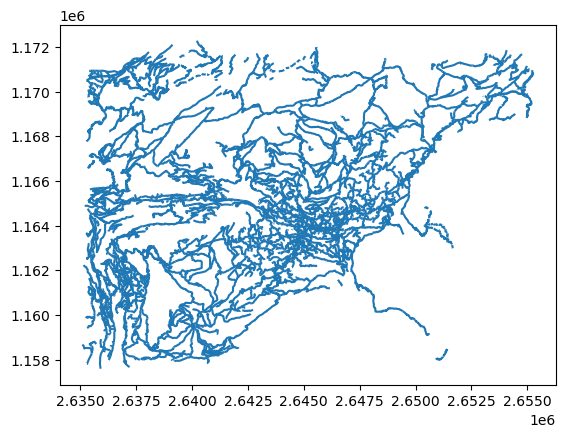

In [12]:
if __name__ == "__main__":
    #gdf = gpd.read_file('../data/Roads_small.gpkg') #change the path
    #gdf = gpd.read_file('/Users/baoyuliu/Documents/GitHub/G877_Alivand/Roads_small.gpkg')

    graph_file_path = os.path.join('/Users', user_name, 'Documents/GitHub/G877_Alivand', 'Roads_small.gpkg')
    gdf = gpd.read_file(graph_file_path)
    #gdf = gpd.read_file('/Users/user_name/Documents/GitHub/G877_Alivand/final_clean_combined.gpkg')
    m=0
    
    # generate the graph stored in the adjacency list
    road_graph = preprocess_gdf(gdf)

    print(road_graph.adj_list)
    #gdf = gpd.read_file('Roads_small.gpkg')
    graph = preprocess_gdf(gdf)
    fig, ax = plt.subplots()
    gdf.plot(ax=ax)
    plt.show()
    
    '''
    #generate the graph stored in the adjacency list
    road_graph = preprocess_gdf(gdf)
    for v, w in road_graph.adj.items():
        print("Node:", v, "Edges:", w)
        node = road_graph.get_node(v)
        print("Latitude:", node.x, "Longitude:", node.y)
        m+=1
    print(m)

    edge_list_graph = preprocess_gdf_to_edge_list(gdf)
    for edge in edge_list_graph.edges[:10]:
        print("Edge:", edge)
    '''

    #matrix_graph = preprocess_gdf(gdf, graph=Graph_matrix())
    #print(matrix_graph.dis_matrix)

In [13]:
# Point class for scenicness scoring

class Point():
    # initialise
    def __init__(self, x=None, y=None, cat=None):
        self.x = x
        self.y = y
        self.cat = cat

     # representation
    def __repr__(self):
        return f'Point(x={self.x}, y={self.y})'

    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    # method to find the closest pixel center
    def find_closest_pixel(self, pixel_centers):
        distances = [self.distEuclidean(center) for center in pixel_centers]
        closest_index = distances.index(min(distances))
        closest_pixel_center = pixel_centers[closest_index]
        return closest_pixel_center
    
    # method to find the neighbors of a given pixel center
    def find_neighbors(self):
        neighbors = []
        for dx in [-100, 0, 100]:
            for dy in [-100, 0, 100]:
                neighbor_point = Point(self.x + dx, self.y + dy, self.cat)
                neighbors.append(neighbor_point)
        return neighbors
    
    # static method to get landcover values for neighborhood
    @staticmethod
    def get_landcover(neighborhood):
        values = [point.cat for point in neighborhood]
        return values

In [14]:
# Reload the cleaned graph data
gdf = gpd.read_file('./data/clean_graph.gpkg')
graph = preprocess_gdf(gdf, graph=Graph())

geom = []
lengths = []
delete_index = []
# Nodes with exactly two edges are identified as intermediary node
mitnodes = [node_idx for node_idx, edges in graph.adj_list.items() if len(edges) == 2]
for node_idx in tqdm(mitnodes, desc="processing"):
    pointslist = []
    # Visit nodes connected to the intermediary node and collect their coordinates
    MergeMitnodes.visit_node(graph, mitnodes, node_idx)
    pointslist = list(set(pointslist))  # Remove duplicate coordinates
    print(pointslist)
    geometries = []
    lines_length = []
    # Iterate through all pairs of collected coordinates
    for i in range(len(pointslist)):
        for j in range(i + 1, len(pointslist)):
            node1 = pointslist[i]
            node2 = pointslist[j]
            # Find the multi-line string and its index in the GeoDataFrame
            multilinestring, idx, length = MergeMitnodes.find_multilinestring(graph, node1, node2, gdf)
            if multilinestring is not None:
                geometries.append(multilinestring)
                delete_index.append(idx)
                lines_length.append(length)
    # Calculate total length of merged geometries
    total_length = sum(lines_length)
    lengths.append(total_length)
    print(len(geometries))
    # Merge multi-line strings
    merged_multilinestring = MergeMitnodes.merge_multilinestrings(geometries)
    print(merged_multilinestring)
    geom.append(merged_multilinestring)

processing:   0%|          | 0/1278 [00:00<?, ?it/s]


TypeError: 'method' object is not subscriptable

In [15]:
# Create a new GeoDataFrame containing the merged geometries
gdf = gpd.GeoDataFrame(geometry=geom, crs='EPSG:2056')
gdf['SHAPE_Length'] = lengths
output_file = '../new_clean_combined.gpkg'
# Save the GeoPackage file
gdf.to_file(output_file, driver='GPKG')
print(f"GeoPackage file has already been saved to : {output_file}")

# Save the indices of deleted geometries to a CSV file
delete_index_file = '../new_clean_delete_index.csv'
with open(delete_index_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for index in delete_index:
        writer.writerow([index])
print(f"Delete index has already been saved to: {delete_index_file}")


GeoPackage file has already been saved to : ../new_clean_combined.gpkg
Delete index has already been saved to: ../new_clean_delete_index.csv


c:\Users\Fabio\anaconda3\envs\geo876\Lib\site-packages\geopandas\io\file.py:633: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


GeoPackage file has already been saved to : ../final_clean_combined.gpkg


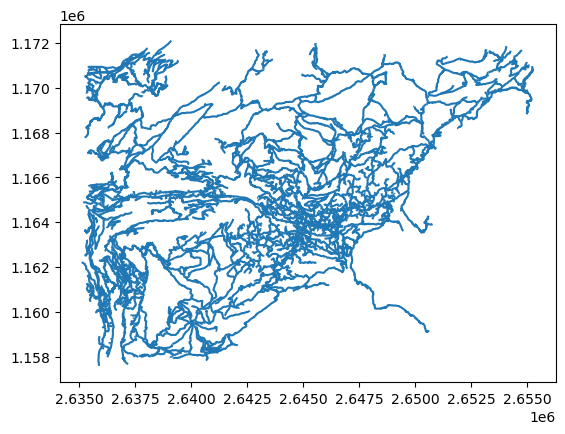

In [16]:
# Load the indices of geometries to delete
to_delete = pd.read_csv("./new_clean_delete_index.csv")

# Load the combined GeoPackage file
input_file = ('./new_clean_combined.gpkg')
combined_gdf = gpd.read_file(input_file)

# Load the original cleaned graph GeoPackage file
gdf = gpd.read_file('./clean_graph.gpkg')

# Initialize a matplotlib figure and axis for plotting
fig, ax = plt.subplots()

# Convert the to_delete DataFrame to a list
to_delete_list = to_delete.iloc[:, 0].tolist()

# Remove geometries from gdf based on indices in to_delete_list
gdf.drop(to_delete_list, inplace=True)
gdf.reset_index(drop=True, inplace=True)

# Keep only the 'SHAPE_Length' and 'geometry' columns in gdf
gdf = gdf[['SHAPE_Length','geometry']]

# Rename the 'length' column in combined_gdf to 'SHAPE_Length'
combined_gdf.rename(columns={'length': 'SHAPE_Length'}, inplace=True)

# Concatenate gdf and combined_gdf along rows, ignoring index
new_gdf = pd.concat([gdf.reset_index(drop=True), combined_gdf.reset_index(drop=True)], axis=0, ignore_index=True)

# Save the combined GeoPackage file
output_file =('../final_clean_combined.gpkg')
new_gdf.to_file(output_file, driver='GPKG')

# Reset the index of new_gdf
new_gdf.reset_index(drop=True, inplace=True)

# Print the path to the saved GeoPackage file
print(f"GeoPackage file has already been saved to : {output_file}")

# Plot the geometries in new_gdf
new_gdf.plot(ax=ax)
plt.show()


## Data loading

Loading the required datasets for the analysis.

### Load the land use statistic

The land use statistic (LUS) is in csv format.

In [17]:
# Create a path to the CSV file of the land use statistic
csv_file_path = os.path.join('/Users', user_name, 'Documents', 'GitHub', 'G877_Alivand', 'arealstatistik_Grindelwald.csv')

# Load land use statistic data
arealstatistik_GW = pd.read_csv(csv_file_path, sep=';')
#print(arealstatistik_GW)
#arealstatistik_GW.info()

### Load the DHM25

The DHM25 is in geojson format.

In [18]:
# Create a path to the file of the DHM25
dhm25_file_path = os.path.join('/Users', user_name, 'Documents', 'GitHub', 'G877_Alivand', 'DHM25_Grindelwald.geojson')

# Load DHM25 data
dhm25 = gpd.read_file(dhm25_file_path)
#print(dhm25)
print(arealstatistik_GW.head())
print(dhm25.head())

   E_COORD  N_COORD  AS18_4
0  2620000  1150100       2
1  2620000  1151400       4
2  2620000  1151800       4
3  2620000  1151900       4
4  2620000  1152200       4
   OBJECTID                                    geometry
0   8651321  POINT Z (2625485.900 1172295.300 1584.000)
1   8651327  POINT Z (2627831.300 1172885.900 1505.000)
2   8652231  POINT Z (2639148.400 1170993.800 1431.000)
3   8652273  POINT Z (2648728.100 1170739.100 2928.000)
4   8652289  POINT Z (2652621.900 1170375.000 1713.000)


### Populating the classes

In [19]:
# Add the data into the Point class and create an attribute containing the land use category
points_LUS = []

for x in range(len(arealstatistik_GW)):
    a = (Point(arealstatistik_GW['E_COORD'].iloc[x], arealstatistik_GW['N_COORD'].iloc[x]))
    a.cat = arealstatistik_GW['AS18_4'].iloc[x]
    points_LUS.append(a)

print(f'The first 5 points are: {points_LUS[:5]}')
print(f'There are {len(points_LUS)} points in the dataset.')

The first 5 points are: [Point(x=2620000, y=1150100), Point(x=2620000, y=1151400), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620000, y=1152200)]
There are 120701 points in the dataset.


In [20]:
# Split up the DHM25 geometry to fit in our own Point class
dhm25['E_COORD'] = dhm25['geometry'].x.round(1)
dhm25['N_COORD'] = dhm25['geometry'].y.round(1)
dhm25['Z_COORD'] = dhm25['geometry'].z.round(0).astype(int)
#print(dhm25)

# Create points from this data
points_DHM25 = []

for i in range(len(dhm25)):
    point = Point(dhm25['E_COORD'].iloc[i], dhm25['N_COORD'].iloc[i])
    elevation = dhm25['Z_COORD'].iloc[i]
    points_DHM25.append({'point': point, 'elevation': elevation})

print(f'The first 5 points are: {points_DHM25[:5]}')
print(f'There are {len(points_DHM25)} points in the dataset.')
print(f'The elevation of the first point is {points_DHM25[0]["elevation"]}m.a.s.l.')

The first 5 points are: [{'point': Point(x=2625485.9, y=1172295.3), 'elevation': 1584}, {'point': Point(x=2627831.3, y=1172885.9), 'elevation': 1505}, {'point': Point(x=2639148.4, y=1170993.8), 'elevation': 1431}, {'point': Point(x=2648728.1, y=1170739.1), 'elevation': 2928}, {'point': Point(x=2652621.9, y=1170375.0), 'elevation': 1713}]
There are 4280 points in the dataset.
The elevation of the first point is 1584m.a.s.l.


## Visibility analysis

Conducting the analysis of "scenicness" twice, once based on land use statistics and queen neighbourhood (all 8 neighbouring fields) scores and once based on heights and a vicinity radius.
### Land use statistic scenicness

This calculates individual closest points, the points' neighbourhoods, and the landcover values which are then scored according to their (non)scenicness.

In [21]:
# Use class method to find the closest pixel center for each point in points_LUS
# Define an empty list to store the closest pixel centers
closest_pixel_centers = []

# Change the input to nodes/segments for analysis! 
input_closest = points_LUS[:5]

for point in input_closest: 
    closest_pixel_center = point.find_closest_pixel(points_LUS)
    print("Closest pixel center to", point, ":", closest_pixel_center) # this can be removed later on
    closest_pixel_centers.append(closest_pixel_center)

# closest_pixel_centers now contains the closest pixel centers for each Point instance in points_LUS
print(f'The closest pixel centers are: {closest_pixel_centers}')

Closest pixel center to Point(x=2620000, y=1150100) : Point(x=2620000, y=1150100)
Closest pixel center to Point(x=2620000, y=1151400) : Point(x=2620000, y=1151400)
Closest pixel center to Point(x=2620000, y=1151800) : Point(x=2620000, y=1151800)
Closest pixel center to Point(x=2620000, y=1151900) : Point(x=2620000, y=1151900)
Closest pixel center to Point(x=2620000, y=1152200) : Point(x=2620000, y=1152200)
The closest pixel centers are: [Point(x=2620000, y=1150100), Point(x=2620000, y=1151400), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620000, y=1152200)]


In [22]:
# Use class method to find the neighbors of each point in input
# Define an empty list to store the neighborhoods
neighborhoods = []

# Change the input to nodes/segments for analysis! 
input_nn = points_LUS[:5]  

for point in input_nn:
    neighborhood = point.find_neighbors()
    print("Neighborhood of", point, ":", neighborhood)  # Just for debugging, can be removed later
    neighborhoods.append(neighborhood)

# neighborhoods now contains the neighborhoods for each Point instance in input (including the point itself)
print(f'The first 5 neighborhoods are: {neighborhoods[:5]}')

Neighborhood of Point(x=2620000, y=1150100) : [Point(x=2619900, y=1150000), Point(x=2619900, y=1150100), Point(x=2619900, y=1150200), Point(x=2620000, y=1150000), Point(x=2620000, y=1150100), Point(x=2620000, y=1150200), Point(x=2620100, y=1150000), Point(x=2620100, y=1150100), Point(x=2620100, y=1150200)]
Neighborhood of Point(x=2620000, y=1151400) : [Point(x=2619900, y=1151300), Point(x=2619900, y=1151400), Point(x=2619900, y=1151500), Point(x=2620000, y=1151300), Point(x=2620000, y=1151400), Point(x=2620000, y=1151500), Point(x=2620100, y=1151300), Point(x=2620100, y=1151400), Point(x=2620100, y=1151500)]
Neighborhood of Point(x=2620000, y=1151800) : [Point(x=2619900, y=1151700), Point(x=2619900, y=1151800), Point(x=2619900, y=1151900), Point(x=2620000, y=1151700), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620100, y=1151700), Point(x=2620100, y=1151800), Point(x=2620100, y=1151900)]
Neighborhood of Point(x=2620000, y=1151900) : [Point(x=2619900, y=1151800), 

In [23]:
# Use class method to find the land use categories of each neighborhood
neighborhood_landcover = []

for neighborhood in neighborhoods:
    arealstatistik_values = Point.get_landcover(neighborhood)
    neighborhood_landcover.append(arealstatistik_values)
    
print(neighborhood_landcover)

[[2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4]]


In [24]:
# Define a function to calculate the scenicness score of a neighborhood based on the landcover values, where the classes 1 and 3 are considered scenic while 2 and 4 are not
def neighborhood_scenicness(landcover_values):
    count = sum(1 for value in landcover_values if value in [1, 3])
    score = count / 9
    return score


#test with some random data
input_landcover = [[1,2,3,4,1,2,3,4,1],[1,1,1,1,1,1,1,1,1]]

# Test the function for each list of landcover values
for landcover_values in input_landcover:
    scenicness_score = neighborhood_scenicness(landcover_values)
    print("The scenic score of the imaginary neighborhood with the values", landcover_values, "is", scenicness_score)

# test with real data
input_landcover = neighborhood_landcover

# Test the function for each list of landcover values
for landcover_values in input_landcover:
    scenicness_score = neighborhood_scenicness(landcover_values)
    print("The scenic score of the neighborhood with the values", landcover_values, "is", scenicness_score)

The scenic score of the imaginary neighborhood with the values [1, 2, 3, 4, 1, 2, 3, 4, 1] is 0.5555555555555556
The scenic score of the imaginary neighborhood with the values [1, 1, 1, 1, 1, 1, 1, 1, 1] is 1.0
The scenic score of the neighborhood with the values [2, 2, 2, 2, 2, 2, 2, 2, 2] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0


### Height scenicness

This calculates the closest points, searches for all the points in a given radius and calculates the fraction of points that are lower than the closest one.

In [25]:
# Define the function to find the closest pixel center
def find_closest_pixel_DHM25(x_coord, y_coord):
    # Extract coordinates from points_DHM25
    pixel_centers = np.array([(p['point'].x, p['point'].y) for p in points_DHM25])
    
    # Calculate distances
    distances = np.sqrt((pixel_centers[:, 0] - x_coord)**2 + (pixel_centers[:, 1] - y_coord)**2)
    
    # Find the index of the closest point
    closest_index = np.argmin(distances)
    
    # Return the closest pixel center dictionary
    return points_DHM25[closest_index]

x_coord = 2624444
y_coord = 1174444
# Find the closest pixel center
closest_pixel_center_DHM25 = find_closest_pixel_DHM25(x_coord, y_coord)
print("Closest pixel center:", closest_pixel_center_DHM25['point'].x, closest_pixel_center_DHM25['point'].y)
print("Elevation of the closest pixel center:", closest_pixel_center_DHM25['elevation'], "m.a.s.l.")

Closest pixel center: 2624651.5 1174679.7
Elevation of the closest pixel center: 1787 m.a.s.l.


In [26]:
# Define the function to find all points within a given radius
def find_points_within_radius(center_x, center_y, radius=1000):
    points_within_radius = []
    for p in points_DHM25:
        point = p['point']
        distance = np.sqrt((point.x - center_x)**2 + (point.y - center_y)**2)
        if distance <= radius:
            points_within_radius.append(p)
    return points_within_radius

# Find points within 1km radius of the closest pixel center
points_within_radius = find_points_within_radius(closest_pixel_center_DHM25['point'].x, closest_pixel_center_DHM25['point'].y, radius=1000)
print("Number of points within 1km radius:", len(points_within_radius))

# Print the list of points within the radius
print("Points within 1km radius:")
for p in points_within_radius:
    point = p['point']
    elevation = p['elevation']
    print(f"Point: ({point.x}, {point.y}), Elevation: {elevation}m.a.s.l.")

Number of points within 1km radius: 17
Points within 1km radius:
Point: (2624120.3, 1175421.9), Elevation: 1477m.a.s.l.
Point: (2625226.5, 1174079.7), Elevation: 1167m.a.s.l.
Point: (2624810.9, 1174951.6), Elevation: 1818m.a.s.l.
Point: (2624651.5, 1174679.7), Elevation: 1787m.a.s.l.
Point: (2624137.5, 1174312.5), Elevation: 1676m.a.s.l.
Point: (2624054.6, 1174396.9), Elevation: 1725m.a.s.l.
Point: (2625392.1, 1174700.0), Elevation: 1408m.a.s.l.
Point: (2624726.5, 1175265.6), Elevation: 1954m.a.s.l.
Point: (2623962.5, 1174032.8), Elevation: 1634m.a.s.l.
Point: (2624228.1, 1174684.4), Elevation: 1798m.a.s.l.
Point: (2625367.1, 1175348.4), Elevation: 1891m.a.s.l.
Point: (2624089.0, 1174460.9), Elevation: 1694m.a.s.l.
Point: (2625143.8, 1175078.1), Elevation: 1816m.a.s.l.
Point: (2623743.8, 1174976.6), Elevation: 1397m.a.s.l.
Point: (2624543.8, 1174925.0), Elevation: 1834m.a.s.l.
Point: (2624617.1, 1175067.2), Elevation: 1899m.a.s.l.
Point: (2624821.9, 1174701.6), Elevation: 1731m.a.s.l.


In [27]:
# Define the function to compare elevations and calculate the decimal value
def calculate_elevation_comparison(center_point, points_within_radius):
    center_elevation = center_point['elevation']
    lower_count = 0
    higher_count = 0
    
    for p in points_within_radius:
        if p['elevation'] < center_elevation:
            lower_count += 1
        elif p['elevation'] > center_elevation:
            higher_count += 1
    
    total_points = lower_count + higher_count
    if total_points == 0:
        return None  # No points for comparison
    
    lower_decimal = lower_count / total_points
    return lower_decimal

# Calculate and print the elevation comparison decimal value
lower_decimal = calculate_elevation_comparison(closest_pixel_center_DHM25, points_within_radius)
if lower_decimal is not None:
    print(f"Decimal of points lower than the closest pixel center: {lower_decimal:.2f}")
else:
    print("No points found within 1km radius for comparison.")

Decimal of points lower than the closest pixel center: 0.56


## Dijkstra routing algorithm

Running the Dijkstra shortest path algorithm on shortest path by distance and most scenic paths.